In [1]:
#Import Python packages used in the code
#Original packages by Matthias Cuntz
import time as ptime
import sys
import configparser
import os.path
import numpy as np
import pandas as pd
import pyjams as pj
import hesseflux as hf

#Additional packages by Mario Alberto Fuentes Monjaraz 
import datetime as dt
from datetime import timedelta
import altair as alt
import math
from pyproj import Proj
import matplotlib.pyplot as plt
import ee
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import folium
from folium import plugins
from IPython.display import Image
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import time 
import FFP_Python.calc_footprint_FFP_climatology as ffpmodule
import urllib.request

#Activate to visualize the plots in the jupyternotebook
# plots %matplotlib inline

In [2]:
from GppTools import Gpp as gpp

In [3]:
# ee.Authenticate() #For authentifications we require a Google Account registered in GEE (https://earthengine.google.com/)
ee.Initialize()  


In [4]:
dgpp = gpp()
dgpp.collection = 'COPERNICUS/S2_SR_HARMONIZED'
# dgpp.collection = 'MODIS/006/MOD17A2H'

# COPERNICUS_S2_L2A = 'COPERNICUS/S2_SR_HARMONIZED'        #Multi-spectral surface reflectances (https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)
# MODIS_temp        = 'MODIS/006/MOD11A1'                  #Land surface temperature (https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1)
# USAID_prec        = 'UCSB-CHG/CHIRPS/DAILY'              #InfraRed Precipitation with Station dat (https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)
# MODIS_GPP         = 'MODIS/006/MOD17A2H'                 #Gross primary productivity(https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD17A2H)
# MODIS_NPP         = 'MODIS/006/MOD17A3HGF'               #Net primary productivity (https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD17A3HGF)

dgpp.year_list =  [2023] # [2017,2018,2019,2020, 2021, 2022, 2023] 
dgpp.max_cloud_coverage   = 100
dgpp.local_cloud_coverage = 10
dgpp.ndviMask = -100
dgpp.mndviMask = -100
dgpp.bands = ['NDVI','EVI','EVI2','CLr','MNDVI','MNDWI','LSWI','NDII', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
dgpp.crs = 'EPSG:32632'
dgpp.resolution = 10
dgpp.outputdir = 'Output'

In [5]:
file_path = r'C:\Users\fuentesm\Marilu\Deltares\Projects\AGAME\GitHub\vlabs\data\list_sites.xlsx'
df = pd.read_excel(file_path)

In [6]:
df

,country code,site name,station id,main ecosystem,latitude,longitude,elevation,instrument,canopy,Metadata,Unnamed: 10
0,FR,Estrees-Mons A28,FR-EM2,croplands,49.87211,3.020650,85,2.0,0.7,https://meta.icos-cp.eu/resources/stations/ES_...,NaN
1,BE,Lonzee,BE-Lon,croplands,50.55162,4.746234,170,NaN,NaN,https://www.icos-belgium.be/ESLonzee.php,https://meta.icos-cp.eu/resources/stations/ES_...
2,DE,Hohes Holz,DE-HoH,deciduous broadleaf forests,52.08656,11.222350,193,45.0,33.0,https://meta.icos-cp.eu/resources/stations/ES_...,NaN
3,IT,Torgnon,IT-Tor,grasslands,45.84444,7.578055,2168,NaN,NaN,https://meta.icos-cp.eu/resources/stations/ES_...,NaN
4,FI,Hyytiala,FI-Hyy,evergreen needleleaf forests,61.84741,24.294770,181,NaN,NaN,NaN,NaN


In [7]:
df = df[df['station id'] == 'DE-HoH']

In [8]:
for index, row in df.iterrows():

    dgpp.longitude = row['longitude']
    dgpp.latitude = row['latitude']
    dgpp.ID = row['site name'] + '0_cloud' + 'nearest'

    #TODO:Integrate anenometer and displacement height in the list_sites.xlsx file to run this part
    # dgpp.instrument_height_anenometer = row['height anenometer']
    # dgpp.displacement_height = row['displacement_height']
    # fetch = 100*(dgpp.instrument_height_anenometer - dgpp.displacement_height) #Fetch to height ratio https://www.mdpi.com/2073-4433/10/6/299
    #                                                                        #https://nicholas.duke.edu/people/faculty/katul/Matlab_footprint.html 
    fetch = 250 

    lon_lat         =  [dgpp.longitude, dgpp.latitude]
    point = ee.Geometry.Point(lon_lat)
    aoi  = point.buffer(fetch)
    # bbox_coordinates = aoi.bounds().coordinates().get(0)
    # min_x = ee.List(ee.List(bbox_coordinates).get(0)).get(0)
    # min_y = ee.List(ee.List(bbox_coordinates).get(0)).get(1)
    # max_x = ee.List(ee.List(bbox_coordinates).get(2)).get(0)
    # max_y = ee.List(ee.List(bbox_coordinates).get(2)).get(1)
    # bbox = ee.Geometry.Rectangle([min_x, min_y, max_x, max_y]) 
    
    S2_VI_df_interpolate, S2_VI_df = dgpp.calculate_VI_with_area_simplified(dgpp.collection,dgpp.year_list, aoi, dgpp.longitude, dgpp.latitude, dgpp.max_cloud_coverage, dgpp.local_cloud_coverage, dgpp.ndviMask, dgpp.mndviMask, dgpp.bands, dgpp.crs, dgpp.resolution, dgpp.ID, dgpp.outputdir)                                                                


2023
The maximun cloud coverage in the image is: 100
The original size of the collection is 147
The filtered size of the collection is 137


The maximun cloud coverage in the area is: 10
The original size of the collection is 137
The filtered size of the collection is 137


       Exporting: Vegetation_indices.csv




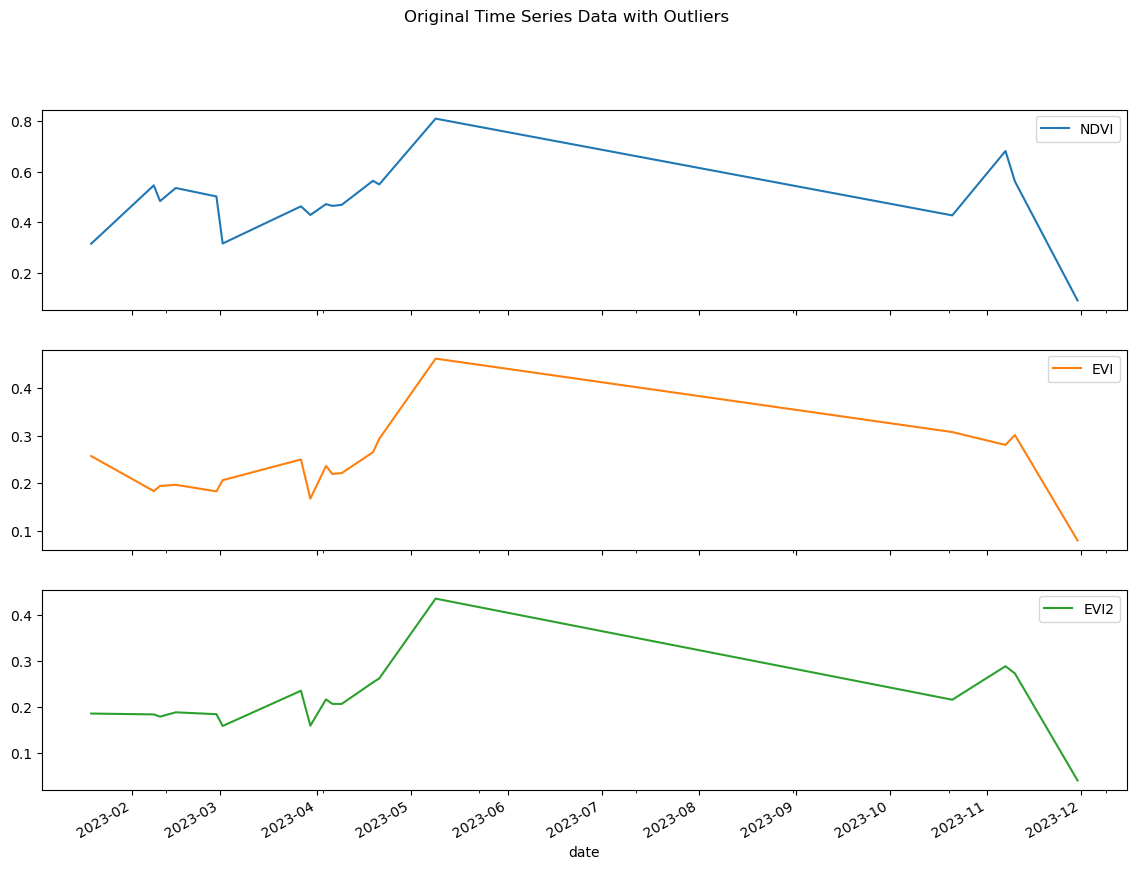

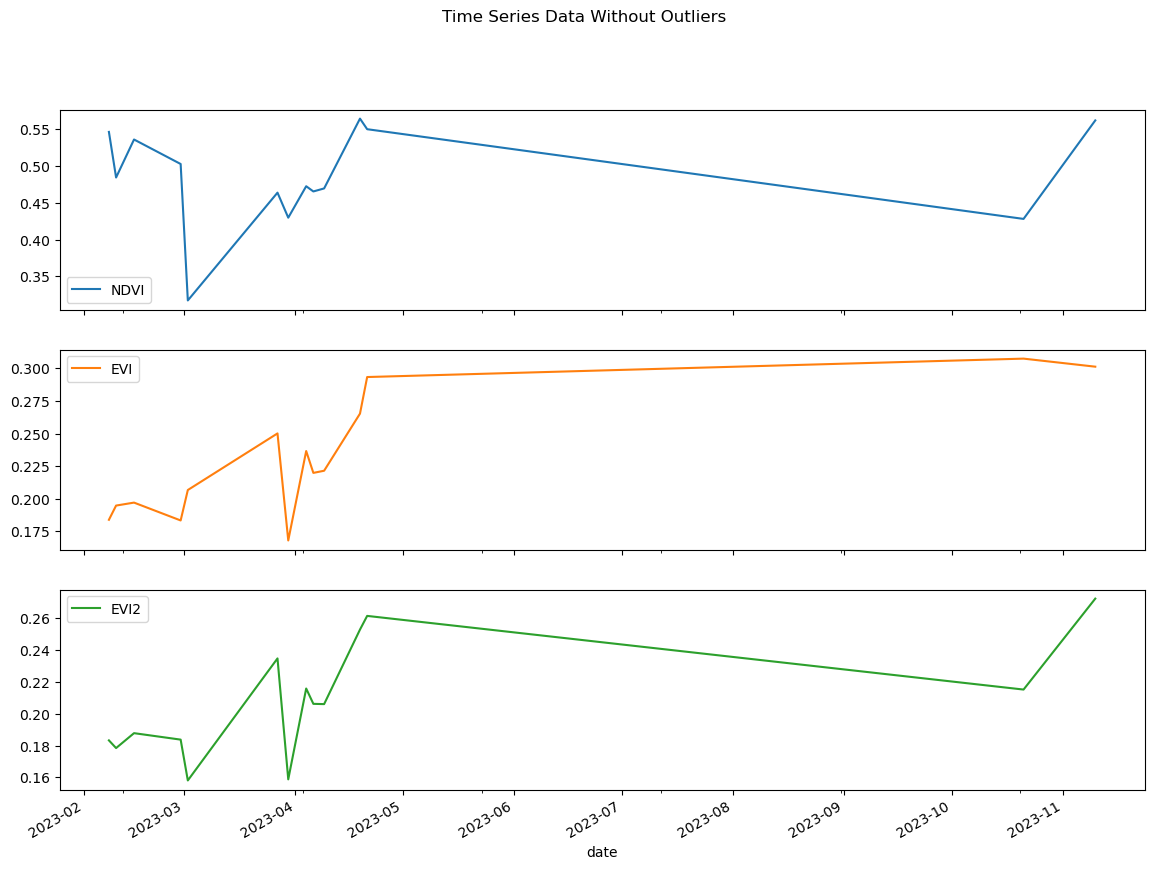

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Function to remove outliers in all columns of a DataFrame
def remove_outliers(df, z_thresh=3):
    df_copy = df.copy()
    # Create a mask for all True values initially
    mask = pd.Series([True] * len(df_copy), index=df_copy.index)
    for column in df_copy.columns:
        # Calculate the Z-scores of the column
        z_scores = np.abs(stats.zscore(df_copy[column].dropna()))
        # Create a mask for the current column
        column_mask = (z_scores < z_thresh)
        # Update the overall mask with AND operation to keep only rows where all columns are within the threshold
        mask &= column_mask.reindex(df_copy.index, fill_value=False)
    # Return the DataFrame with rows where all columns are within the threshold
    return df_copy[mask]

# Plot the original data
S2_VI_df.iloc[:, 0:3].dropna().plot(subplots=True, figsize=(14, 10), title='Original Time Series Data with Outliers')
plt.show()

# Remove outliers from all columns
df_no_outliers_all = remove_outliers(S2_VI_df, z_thresh=2)

# Plot the data without outliers
df_no_outliers_all.iloc[:, 0:3].plot(subplots=True, figsize=(14, 10), title='Time Series Data Without Outliers')
plt.show()

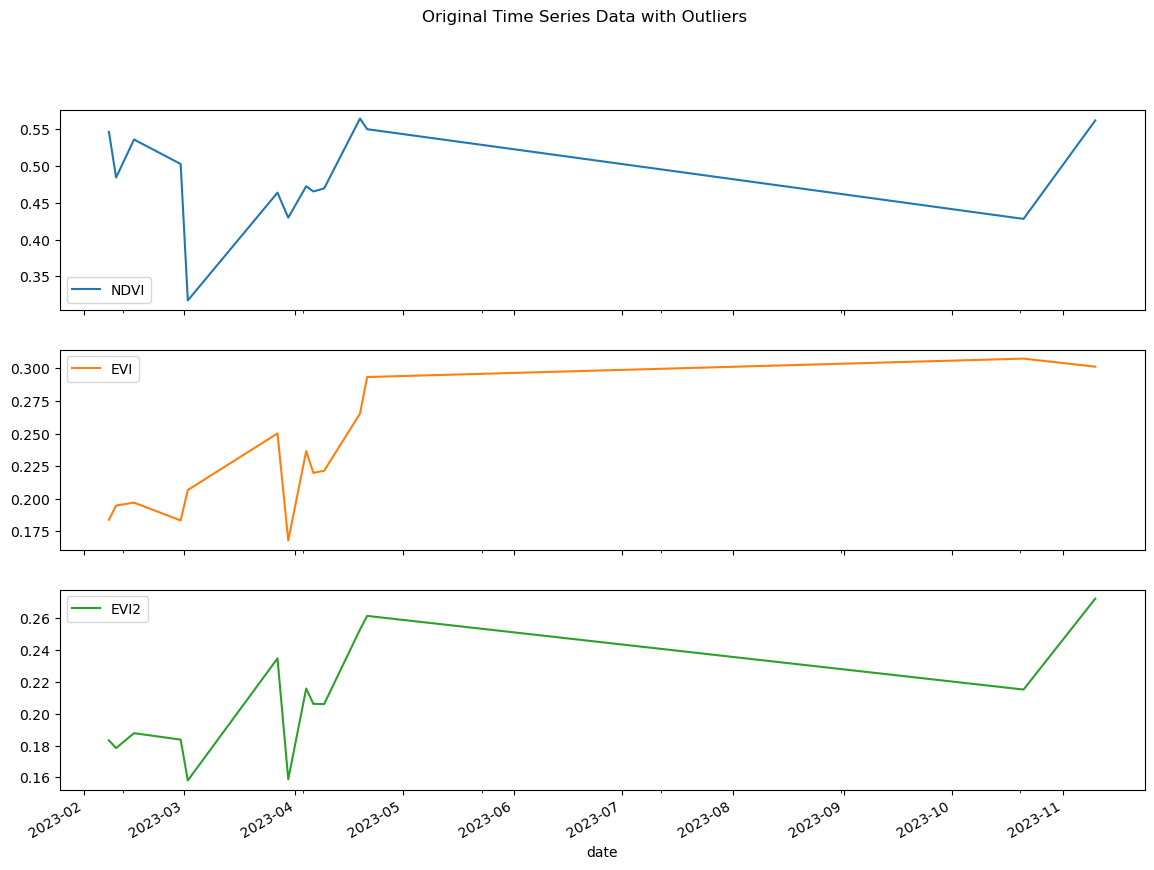

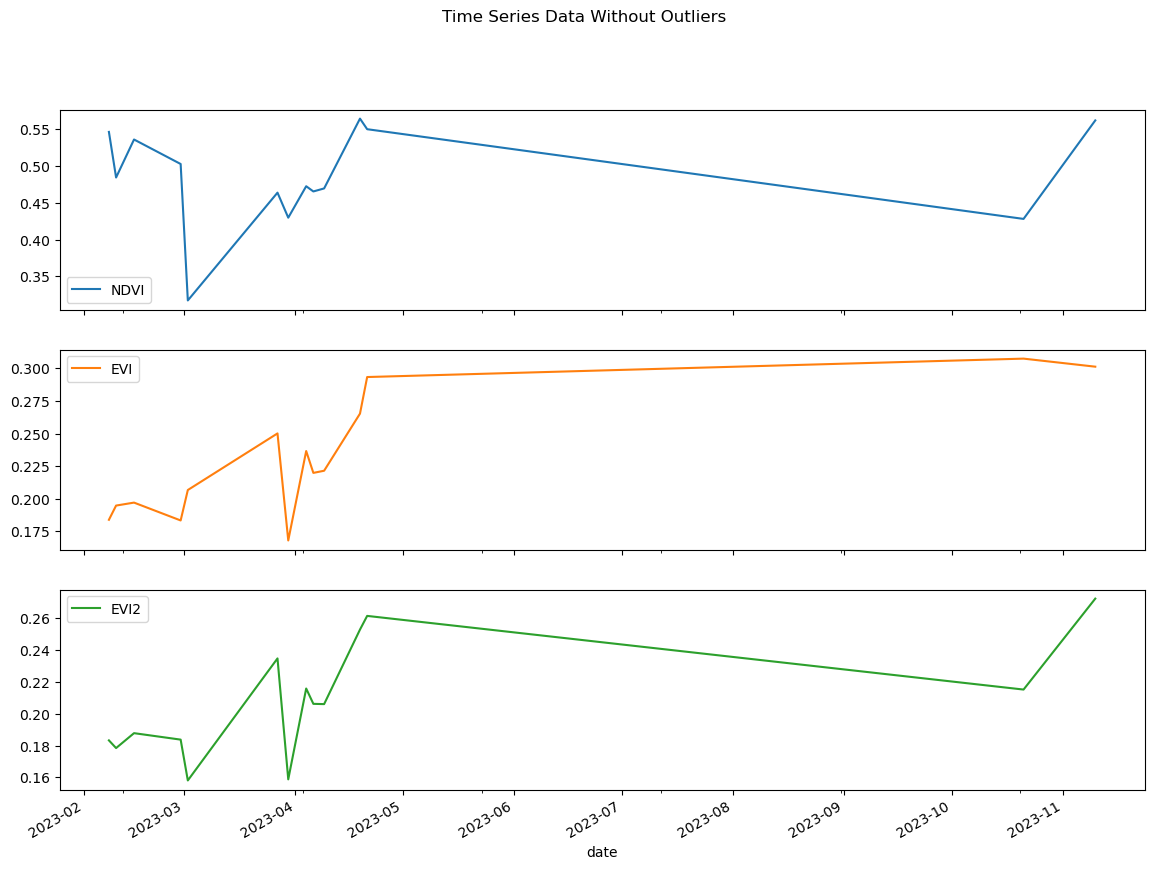

In [10]:
# Plot the original data
df_no_outliers_all.iloc[:, 0:3].plot(subplots=True, figsize=(14, 10), title='Original Time Series Data with Outliers')
plt.show()

# Function to remove outliers in all columns of a DataFrame based on time windows
def remove_outliers_time_window(df, window_size=5, threshold=3):
    df_copy = df.copy()
    for column in df_copy.columns:
        rolling_mean = df_copy[column].rolling(window=window_size, min_periods=1).mean()
        rolling_std = df_copy[column].rolling(window=window_size, min_periods=1).std()
        lower_bound = rolling_mean - threshold * rolling_std
        upper_bound = rolling_mean + threshold * rolling_std
        outliers = (df_copy[column] < lower_bound) | (df_copy[column] > upper_bound)
        df_copy.loc[outliers, column] = np.nan
    return df_copy

# Remove outliers from all columns based on time windows
df_no_outliers_local = remove_outliers_time_window(df_no_outliers_all, window_size=10, threshold=3)

# Plot the data without outliers
df_no_outliers_local.iloc[:, 0:3].dropna().plot(subplots=True, figsize=(14, 10), title='Time Series Data Without Outliers')
plt.show()


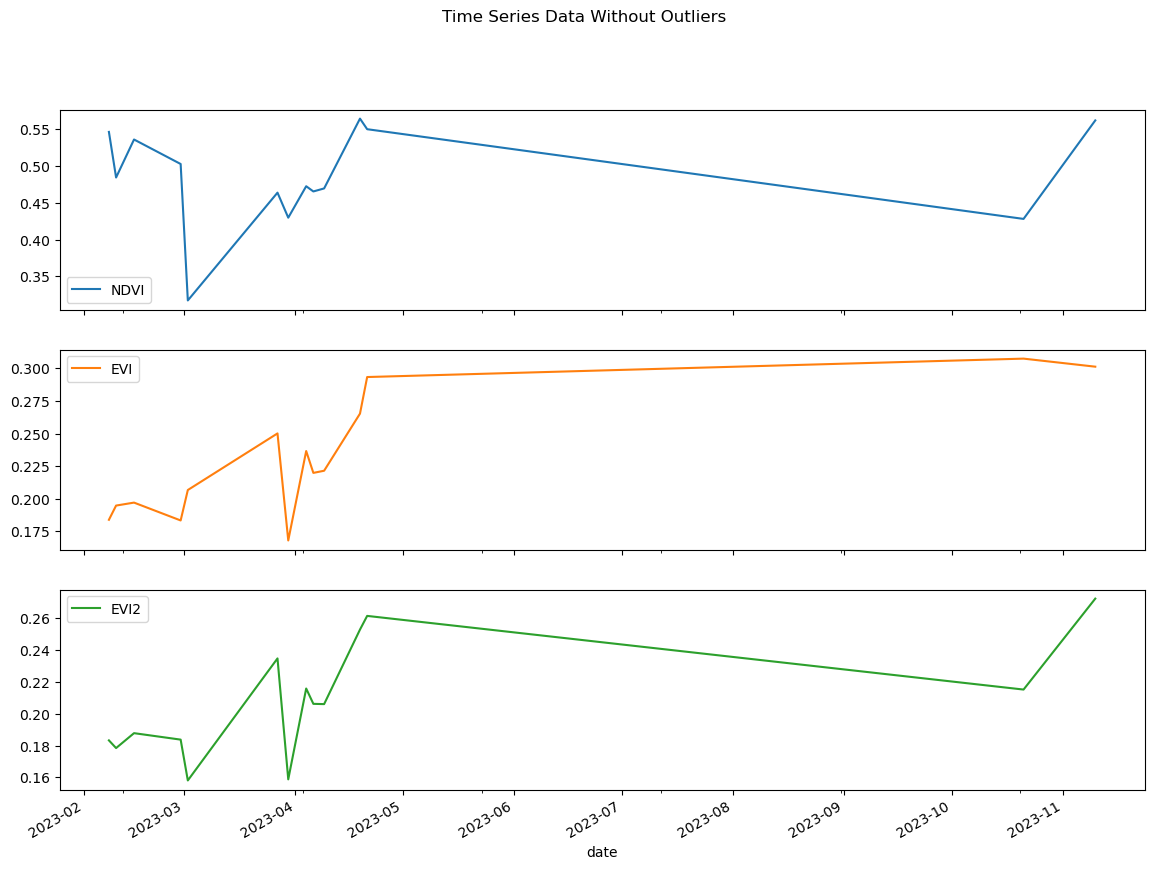

In [11]:
# Plot the data without outliers
df_no_outliers_local.iloc[:, 0:3].dropna().plot(subplots=True, figsize=(14, 10), title='Time Series Data Without Outliers')
plt.show()

# create time series with daily frequency
time_series = pd.date_range(start=str(dgpp.year_list[0]), end=str(dgpp.year_list[-1]+1), freq="D")
time_series = pd.DataFrame(time_series).rename(columns={0: 'date'}).set_index('date')

# allows to have a time series with daily frequency with gaps when the VI were not calculated or there were not S2 images
df_no_outliers_local_time = pd.merge(left= time_series, right=df_no_outliers_local,
                                how="left", left_index = True , right_index = True) 

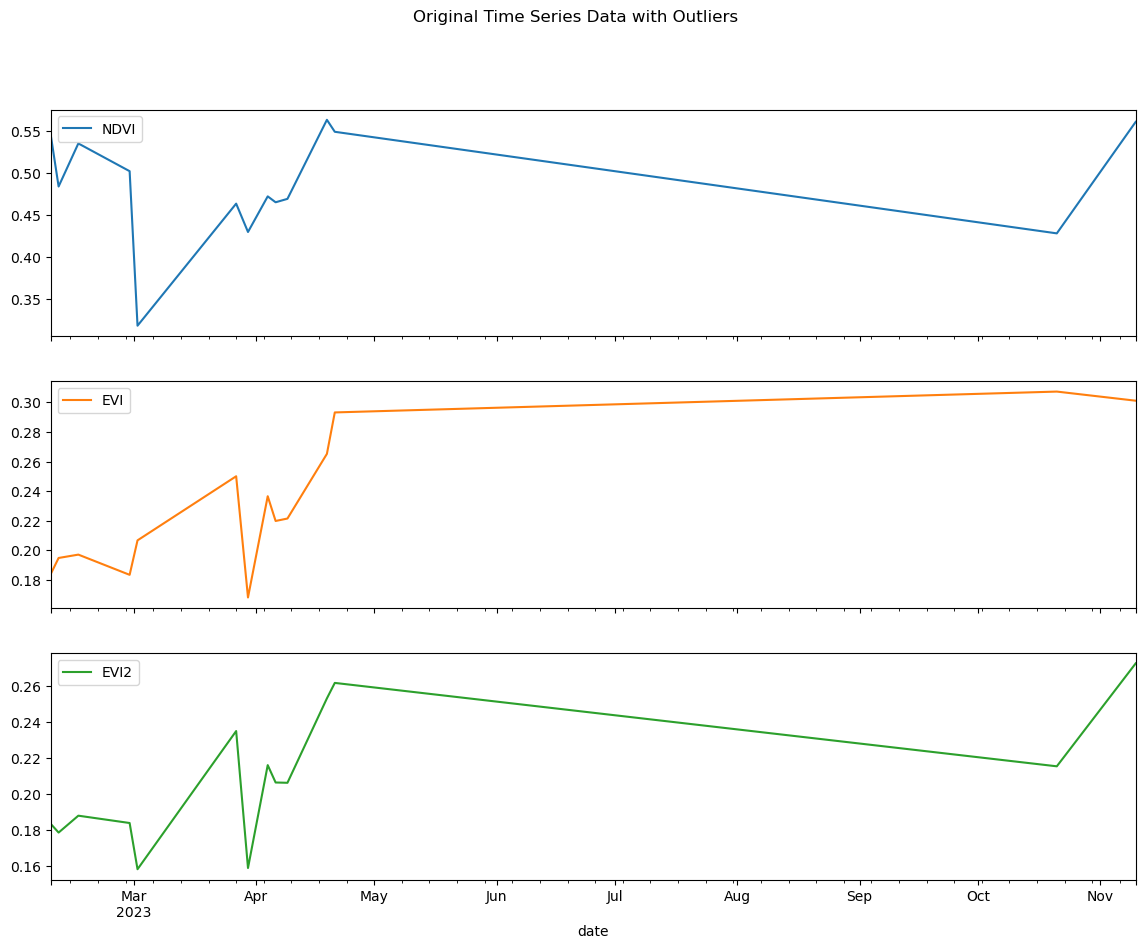

In [12]:
S2_VI_df_interpolate = df_no_outliers_local_time.interpolate(method='polynomial',order=1,  limit_direction ='forward').dropna()

# Plot the original data
S2_VI_df_interpolate.iloc[:, 0:3].plot(subplots=True, figsize=(14, 10), title='Original Time Series Data with Outliers')
plt.show()

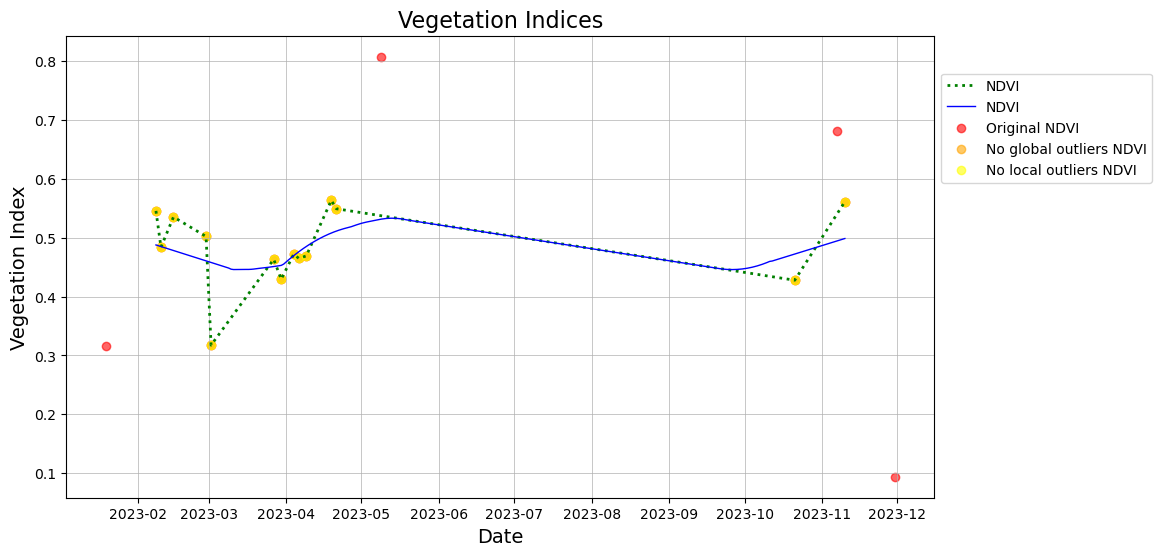

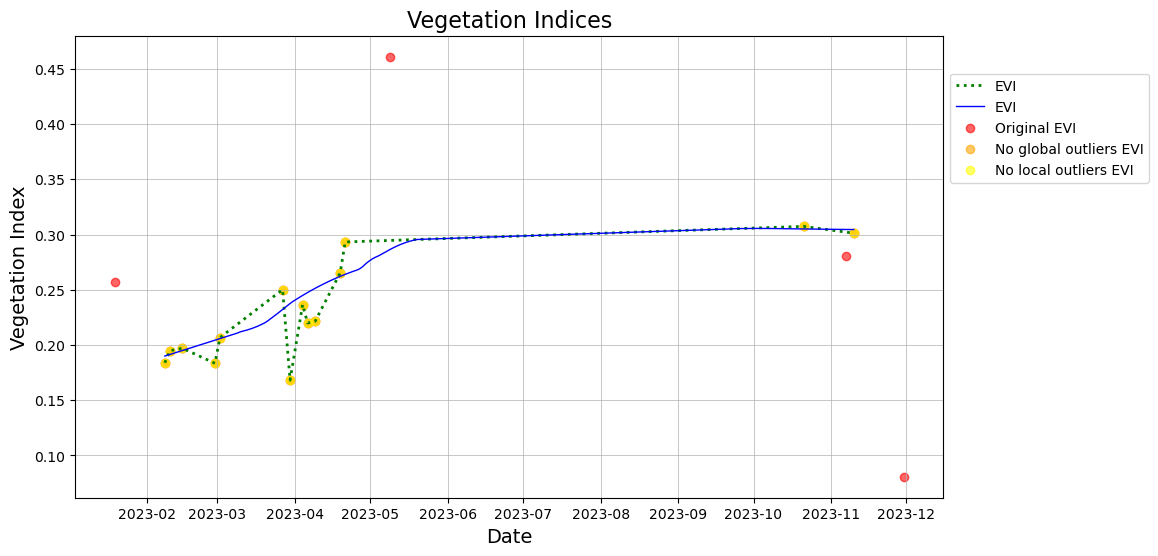

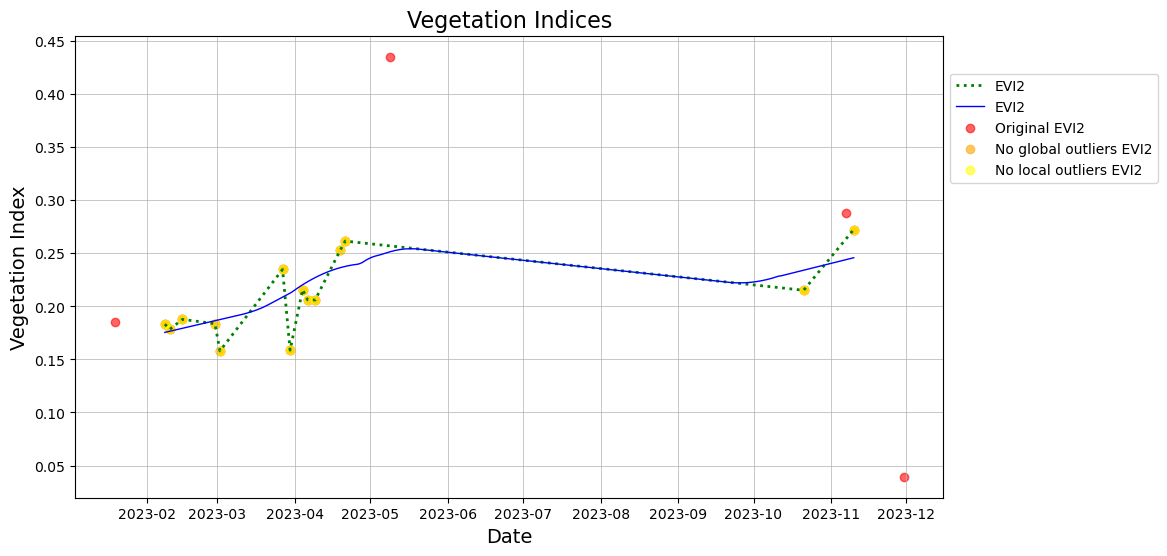

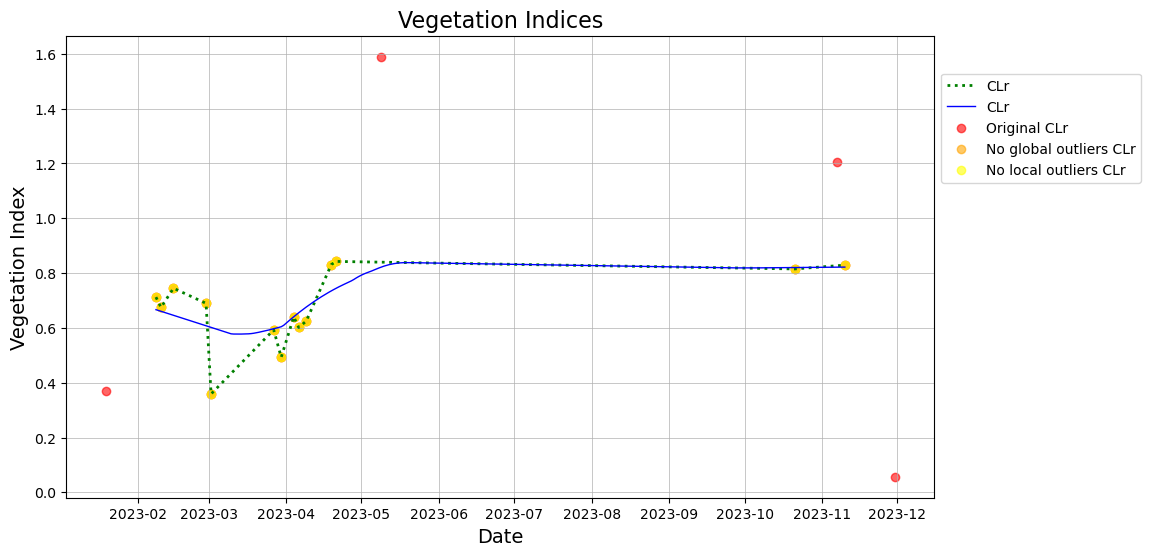

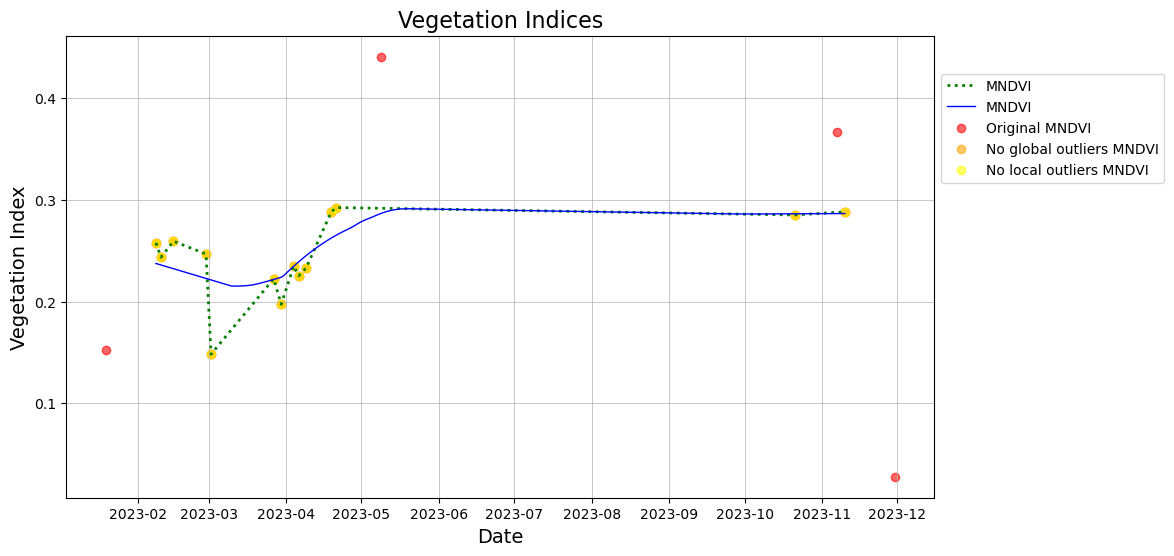

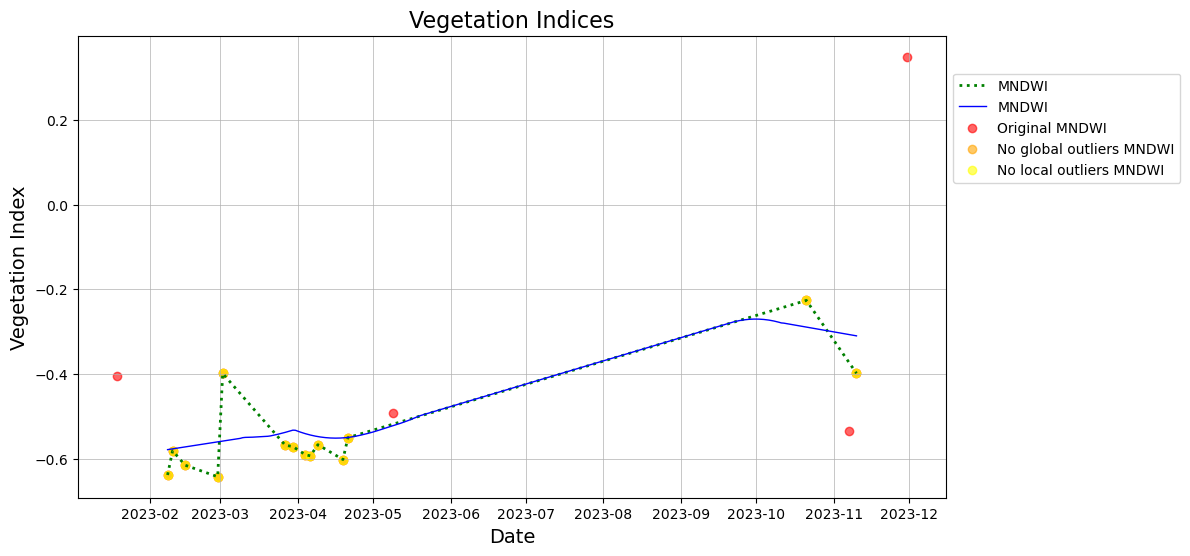

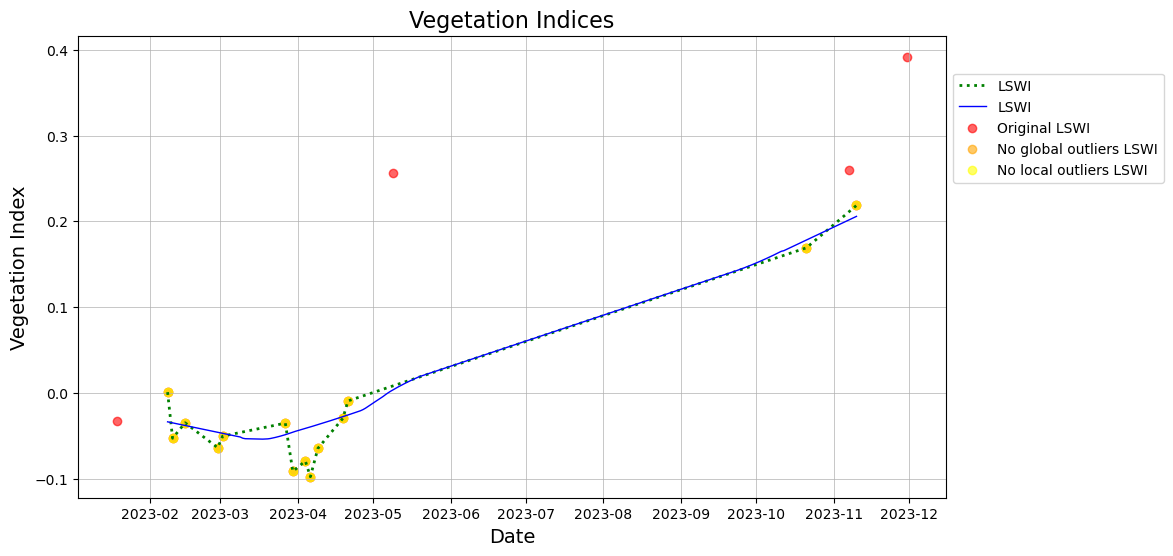

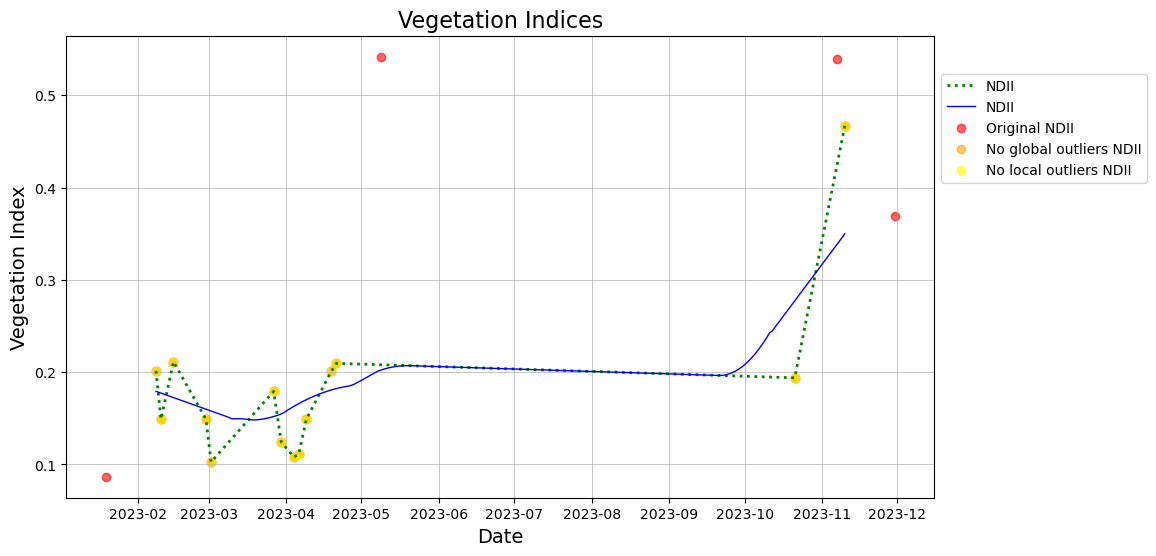

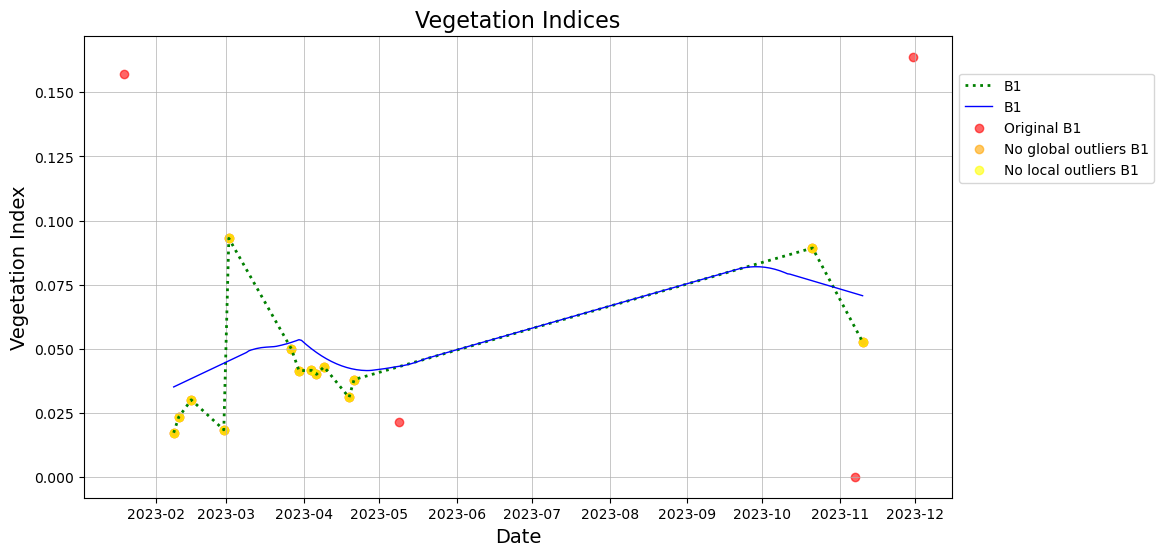

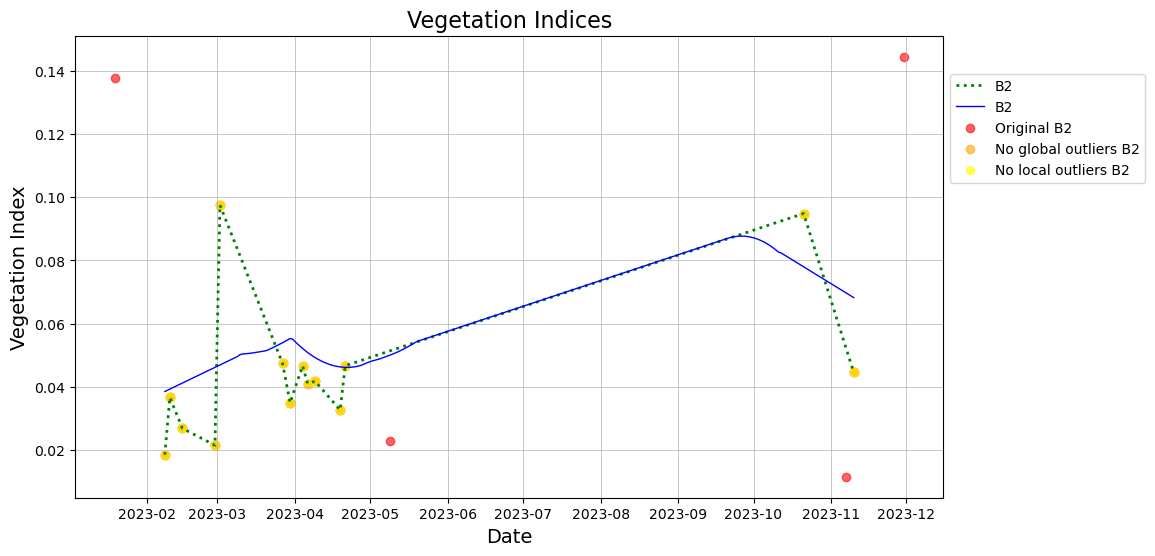

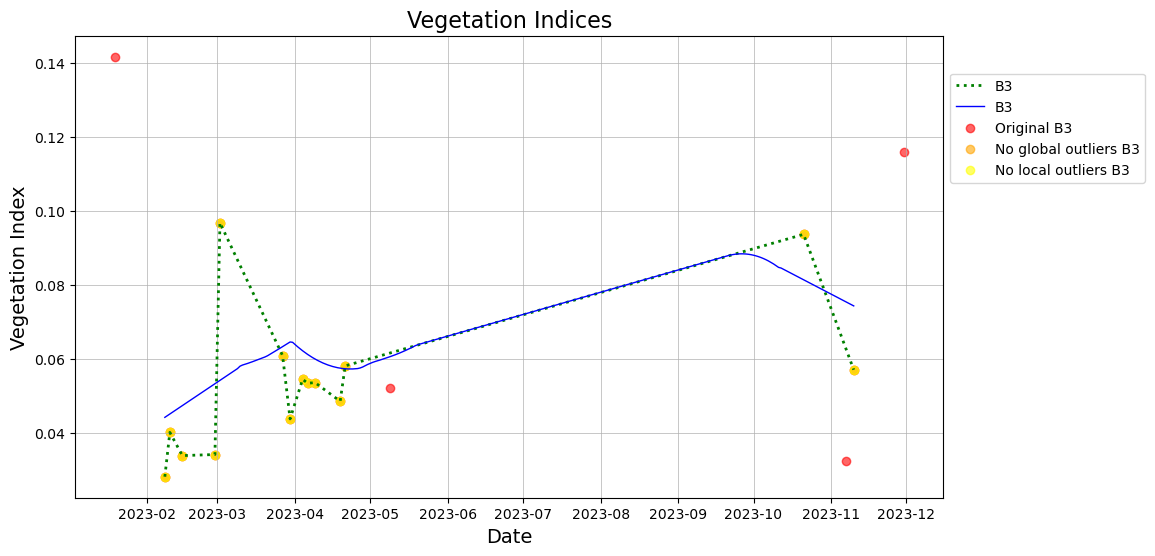

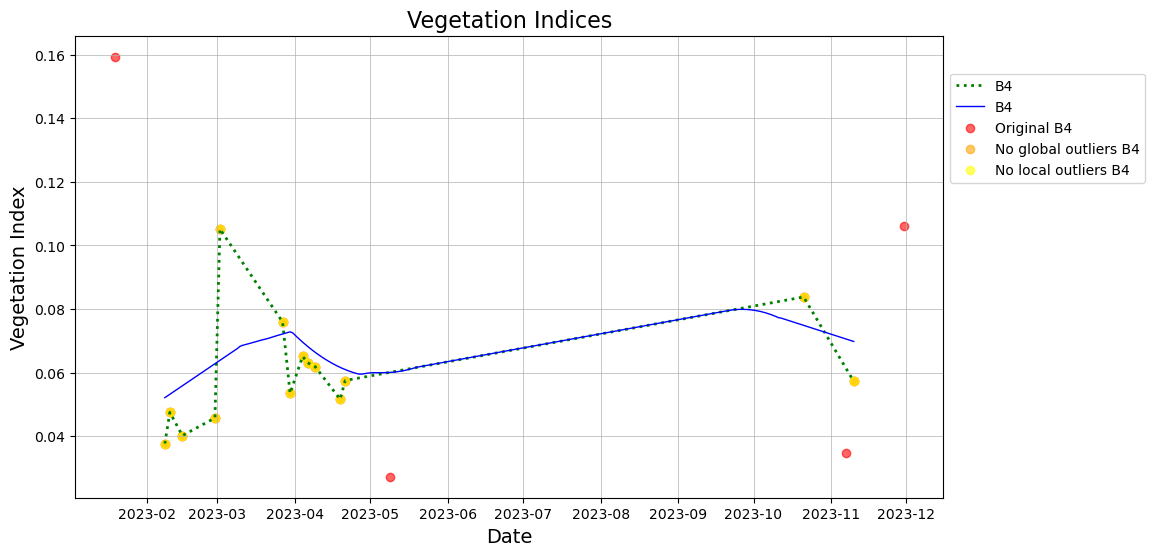

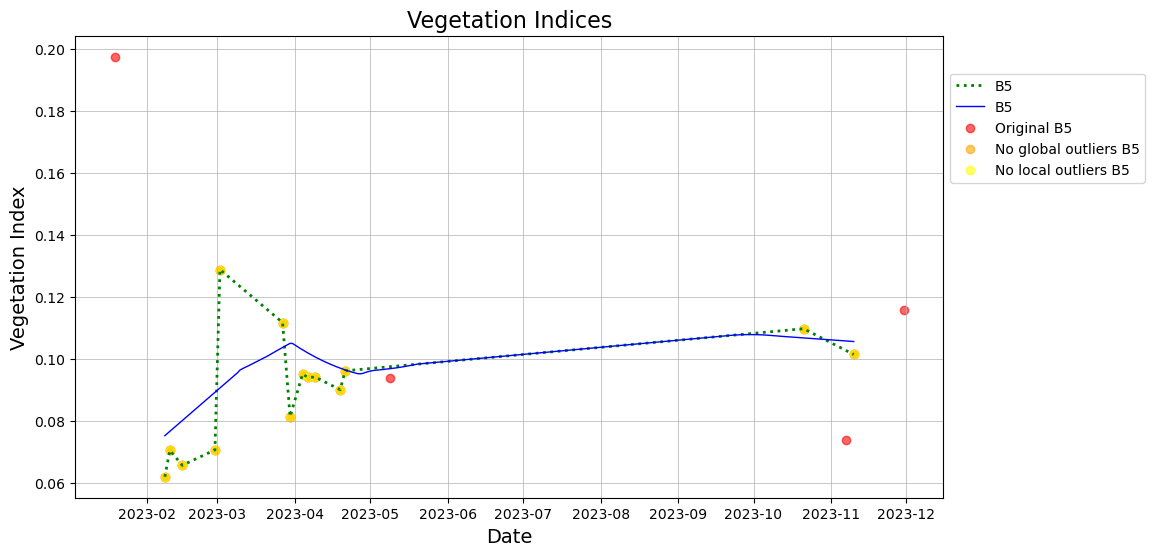

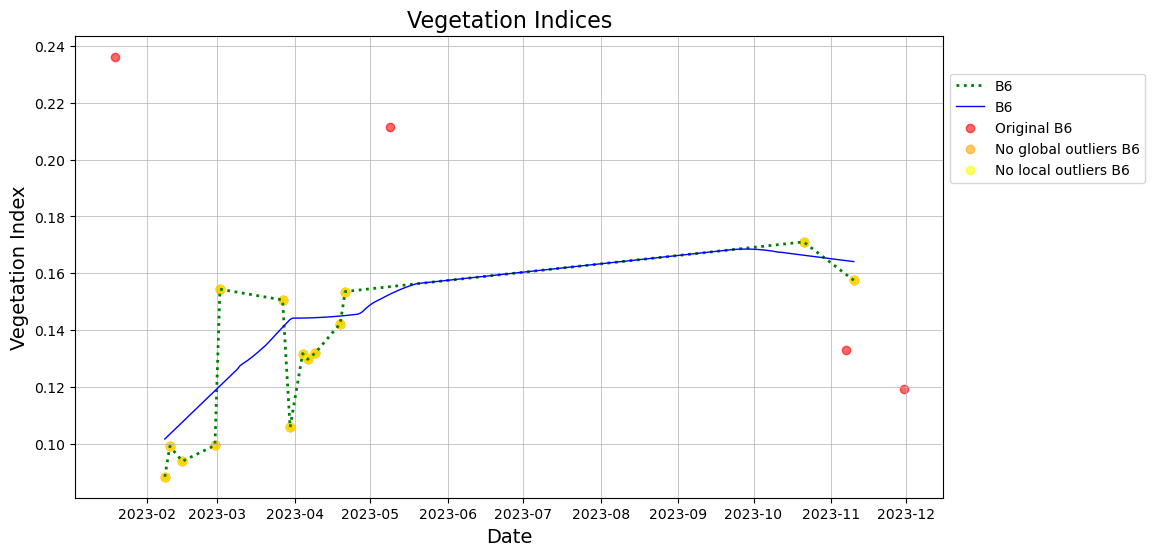

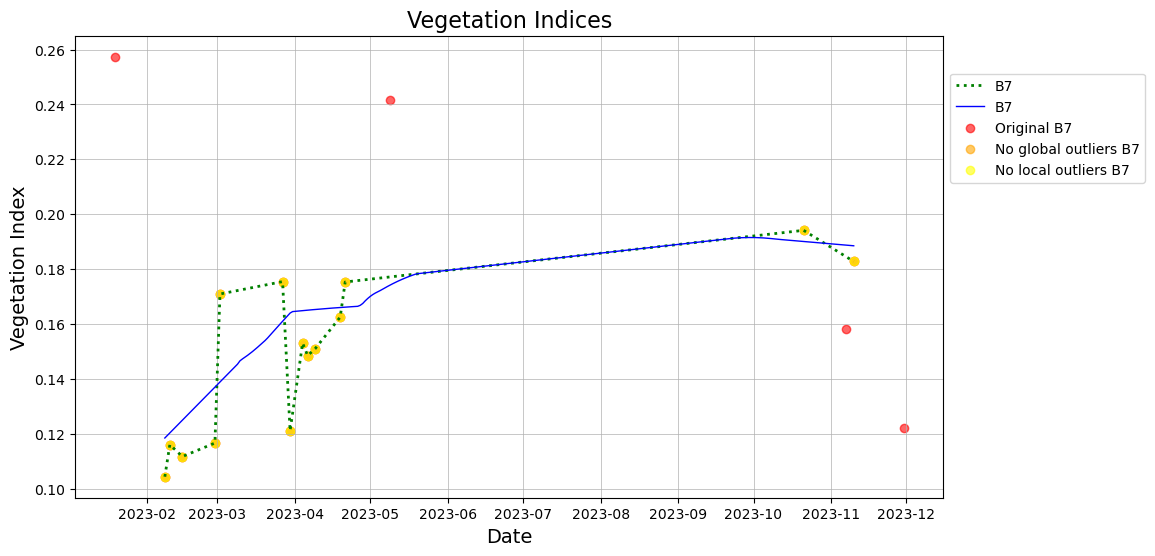

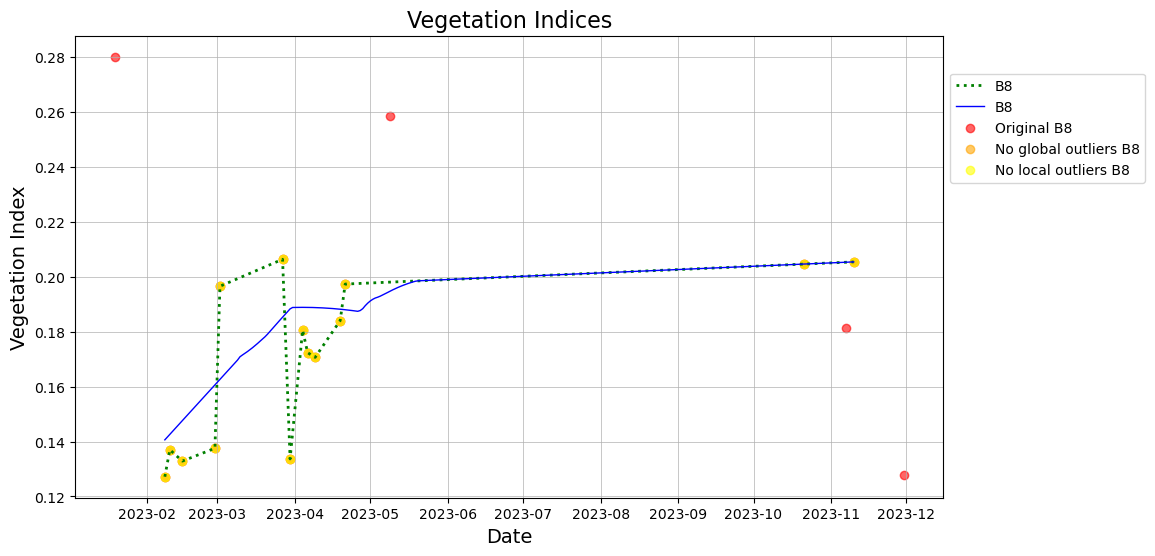

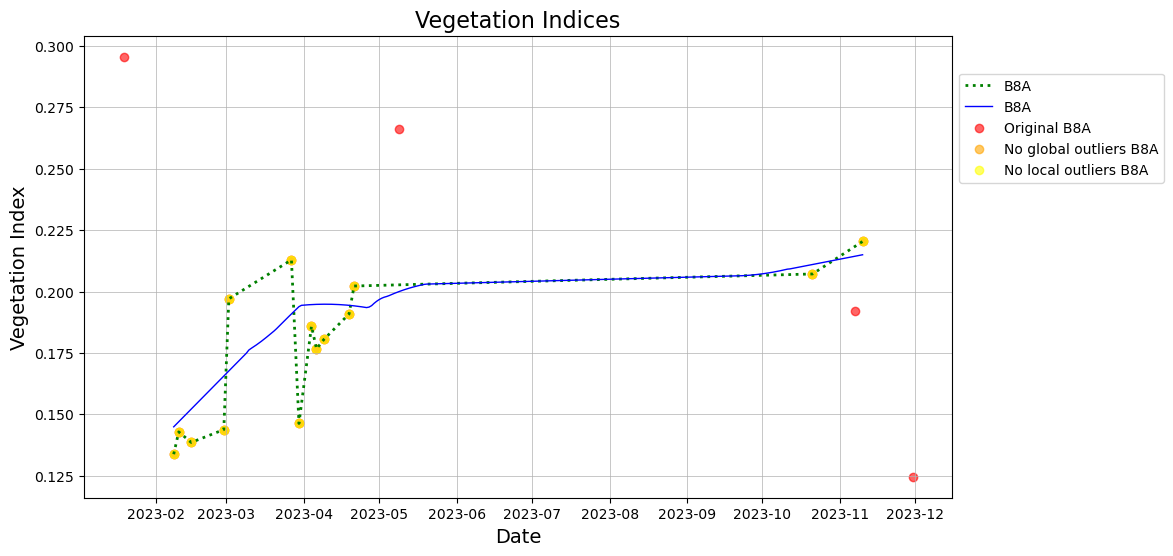

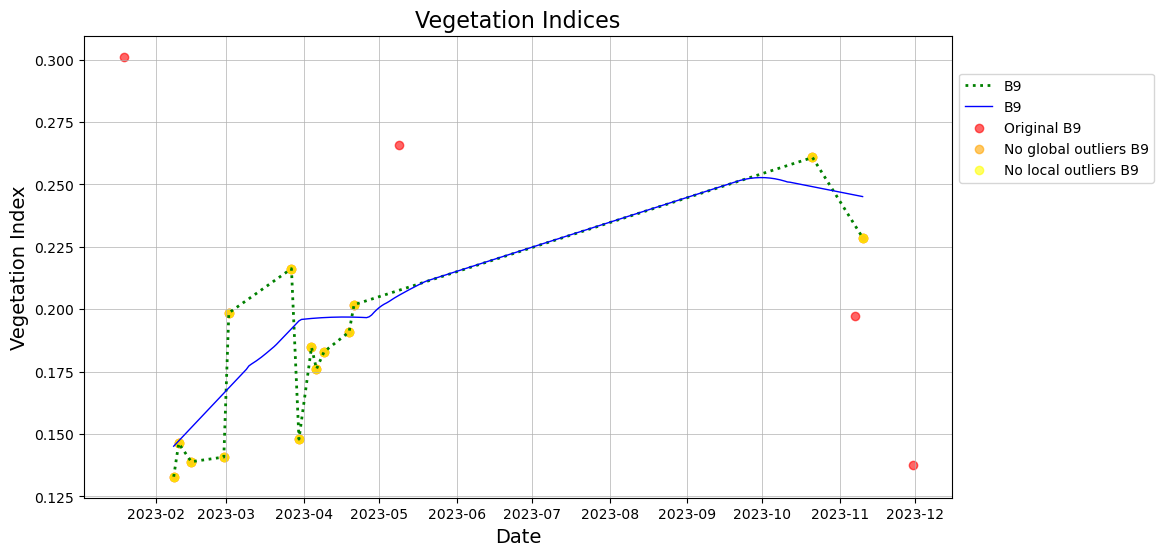

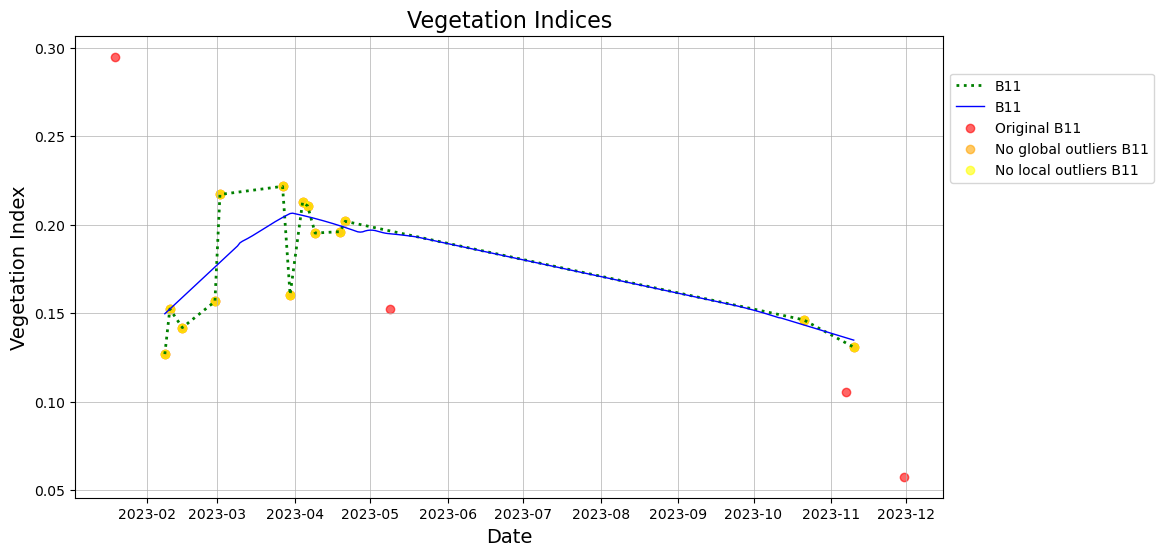

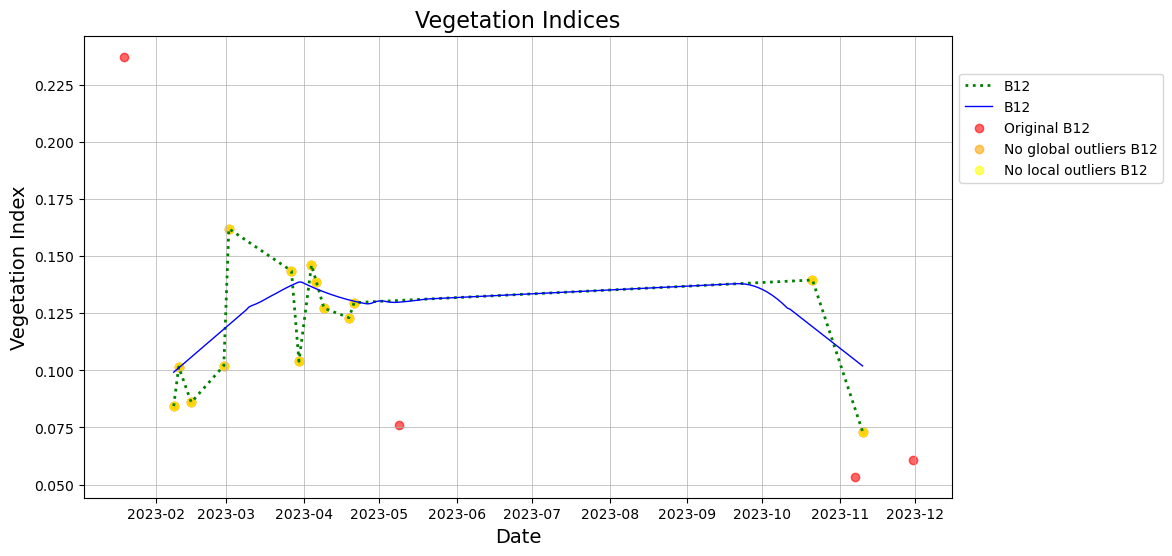

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# # interpolate values
# # S2_VI_df_interpolate = S2_VI_df.interpolate(method='polynomial', order=1, limit_direction ='forward')
# S2_VI_df_interpolate = S2_VI_df.interpolate(method='nearest',  limit_direction ='forward')

# # file to extrapolate
# S2_VI_df_interpolate = S2_VI_df_interpolate.dropna()

# Parameters for Savitzky-Golay filter
window_size = 60  # Must be odd
poly_order = 1

# Apply Savitzky-Golay filter to each column
S2_VI_df_filtered = S2_VI_df_interpolate.apply(lambda x: savgol_filter(x, window_size, poly_order))

#---------------------------------------------------------------------------------------------
# Save plots of VI
def plot_timeseries_vi_multiple(dfint, dffilt, dfraw, vi):
    # subplots.
    fig, ax = plt.subplots(figsize=(14, 6)) #Indicates the size of the plot

    ax.plot(dfint[vi],
                c='green', alpha=1, label=vi, lw=2, linestyle = ':')
    
    ax.plot(dffilt[vi],
                c='blue', alpha=1, label=vi, lw=1, linestyle = '-')
    
    # Add scatter plot for the original data points
    ax.scatter(dfraw.index, dfraw[vi], c='red', alpha=0.6, label=f'Original {vi}', marker='o')

    # Add scatter plot for the original data points
    ax.scatter(df_no_outliers_all.index, df_no_outliers_all[vi], c='orange', alpha=0.6, label=f'No global outliers {vi}', marker='o')

    # Add scatter plot for the original data points
    ax.scatter(df_no_outliers_local_time.index, df_no_outliers_local_time[vi], c='yellow', alpha=0.6, label=f'No local outliers {vi}', marker='o')

    ax.set_title('Vegetation Indices', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Vegetation Index', fontsize=14)
    # ax.set_ylim(-2, 2)
    ax.grid(lw=0.5)
    ax.legend(fontsize=14, loc='lower right')

    # shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, .8))
    #plt.savefig(outputdir + '/VI_output/' + ID + '_VI_timeseries.png', dpi=300, format='png', bbox_inches='tight',pad_inches=0.0001)
    # plt.savefig(outputdir + '/VI_output/' + ID + '_VI_timeseries.png', dpi=300)

    return plt #.show()

for i in dgpp.bands:
    plot_timeseries_vi_multiple(S2_VI_df_interpolate, S2_VI_df_filtered, S2_VI_df, i)



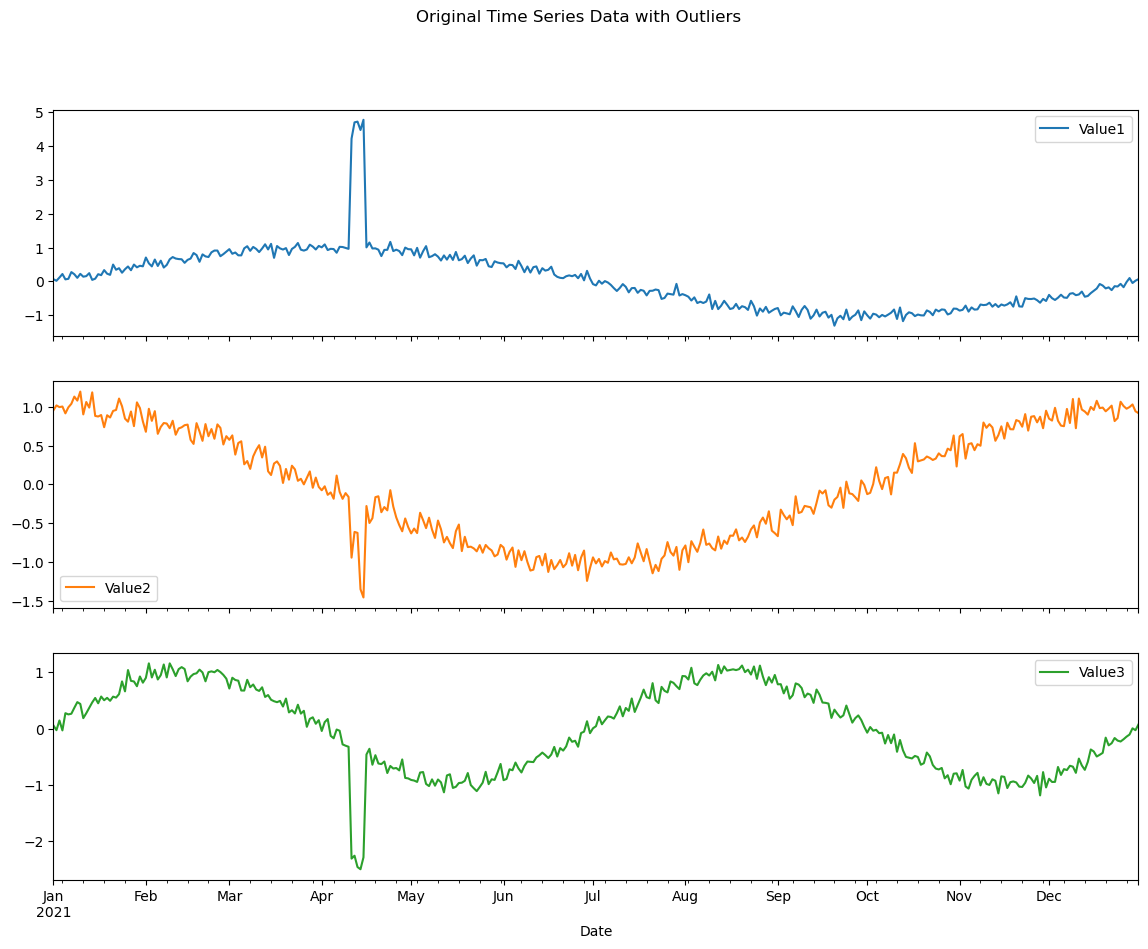

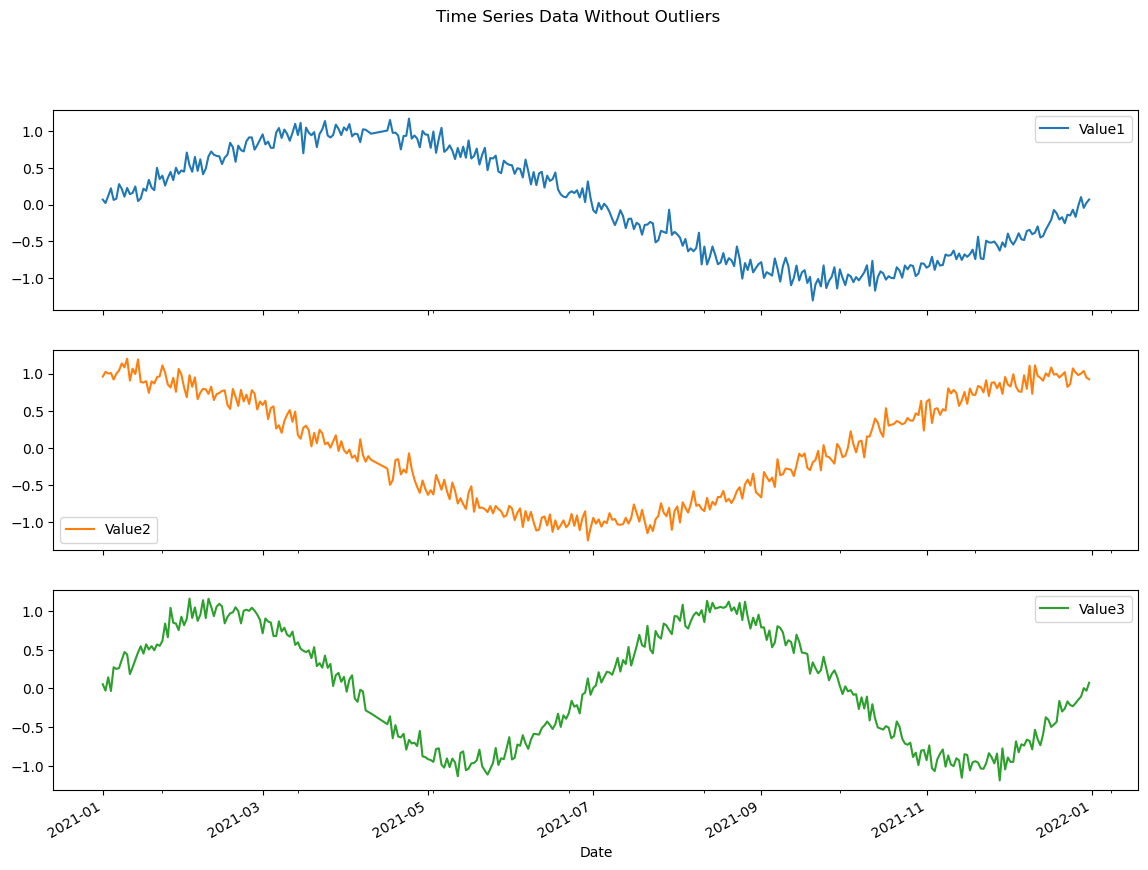

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Sample data: create a time series DataFrame with multiple columns
date_rng = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
np.random.seed(42)
data = {
    'Date': date_rng,
    'Value1': np.sin(2 * np.pi * date_rng.dayofyear / 365) + np.random.normal(scale=0.1, size=len(date_rng)),
    'Value2': np.cos(2 * np.pi * date_rng.dayofyear / 365) + np.random.normal(scale=0.1, size=len(date_rng)),
    'Value3': np.sin(4 * np.pi * date_rng.dayofyear / 365) + np.random.normal(scale=0.1, size=len(date_rng))
}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

# Introduce some outliers
df.iloc[100:105] = df.iloc[100:105] * 5

# Plot the original data
df.plot(subplots=True, figsize=(14, 10), title='Original Time Series Data with Outliers')
plt.show()

# Function to remove outliers in all columns of a DataFrame
def remove_outliers(df, z_thresh=3):
    df_copy = df.copy()
    for column in df_copy.columns:
        z_scores = np.abs(stats.zscore(df_copy[column].dropna()))
        filtered_entries = (z_scores < z_thresh)
        df_copy = df_copy[filtered_entries]
    return df_copy

# Remove outliers from all columns
df_no_outliers = remove_outliers(df, z_thresh=3)

# Plot the data without outliers
df_no_outliers.plot(subplots=True, figsize=(14, 10), title='Time Series Data Without Outliers')
plt.show()


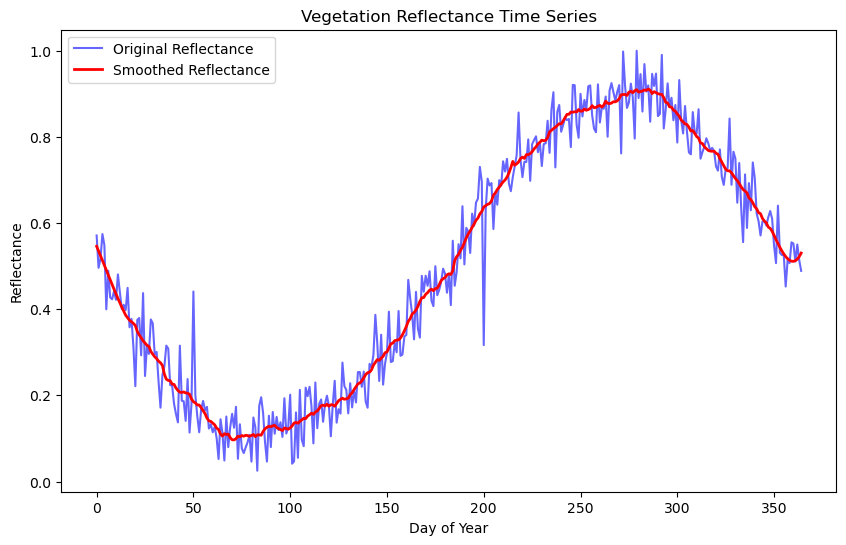

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Generate synthetic time series data for demonstration
np.random.seed(0)  # for reproducibility
time = np.arange(0, 365)  # one year of daily data
# Simulated reflectance: higher in summer (centered around day 180) and lower in winter
reflectance = 0.5 + 0.4 * np.sin(2 * np.pi * (time - 180) / 365) + 0.05 * np.random.randn(len(time))

# Introduce some artificial noise spikes
reflectance[50] += 0.3
reflectance[200] -= 0.3

# Apply Savitzky-Golay filter
window_size = 31  # Must be odd
poly_order = 3
smoothed_reflectance = savgol_filter(reflectance, window_size, poly_order)

# Plot the original and smoothed time series
plt.figure(figsize=(10, 6))
plt.plot(time, reflectance, label='Original Reflectance', color='blue', alpha=0.6)
plt.plot(time, smoothed_reflectance, label='Smoothed Reflectance', color='red', linewidth=2)
plt.xlabel('Day of Year')
plt.ylabel('Reflectance')
plt.title('Vegetation Reflectance Time Series')
plt.legend()
plt.show()


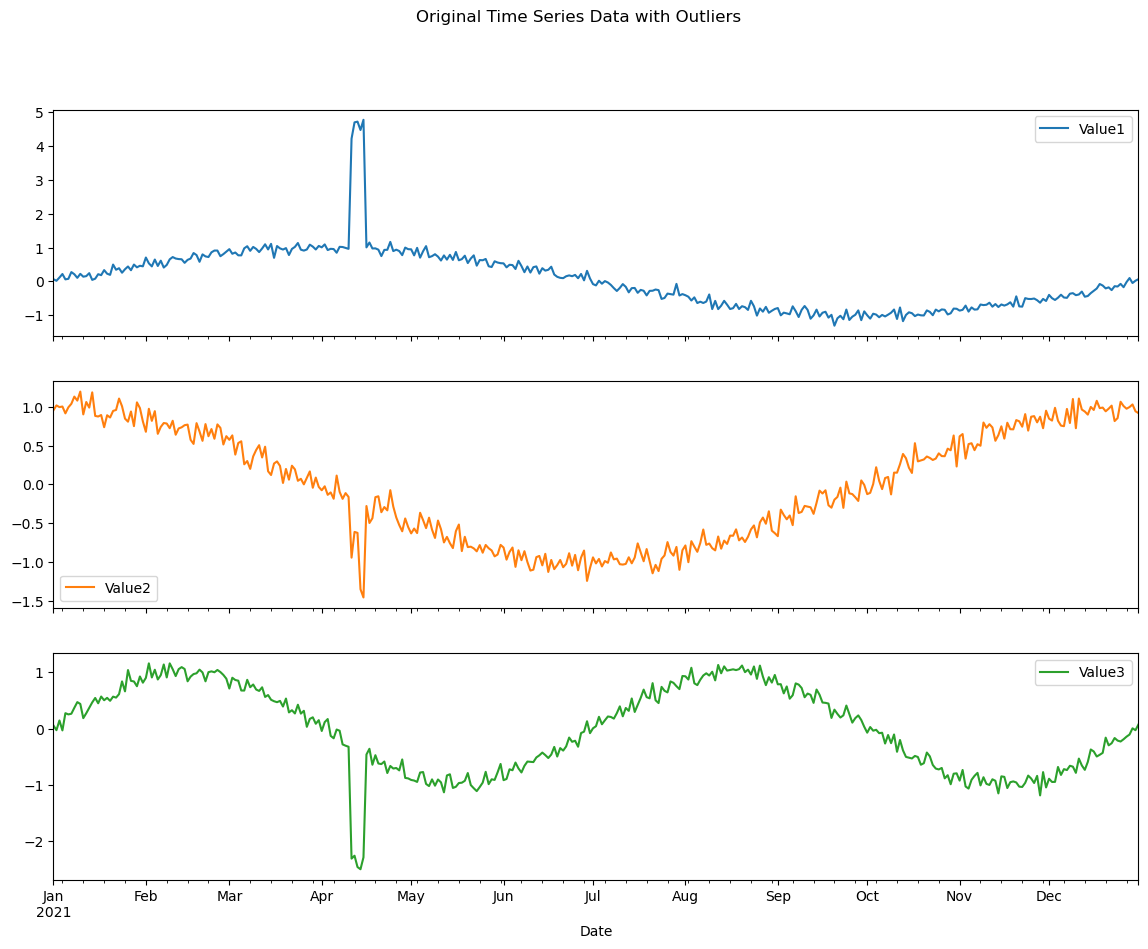

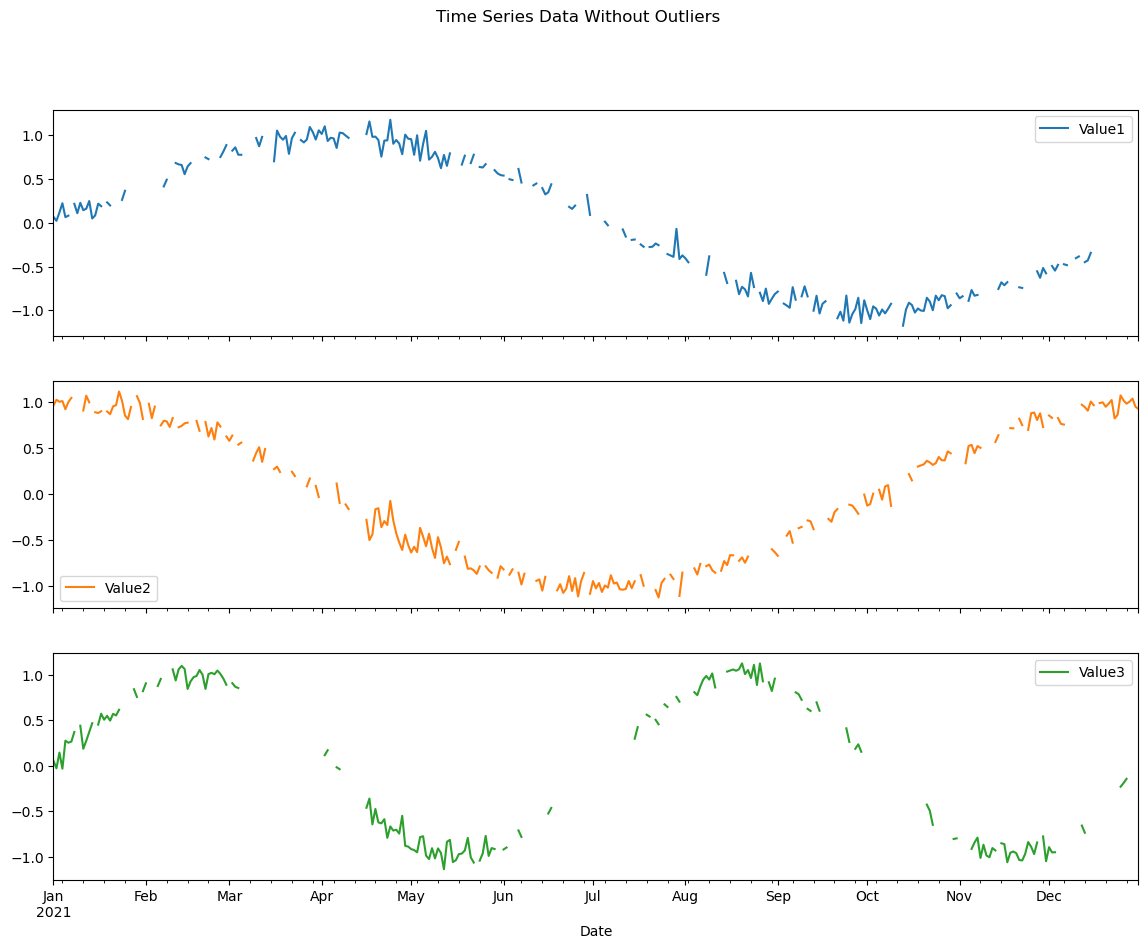

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data: create a time series DataFrame with multiple columns
date_rng = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
np.random.seed(42)
data = {
    'Date': date_rng,
    'Value1': np.sin(2 * np.pi * date_rng.dayofyear / 365) + np.random.normal(scale=0.1, size=len(date_rng)),
    'Value2': np.cos(2 * np.pi * date_rng.dayofyear / 365) + np.random.normal(scale=0.1, size=len(date_rng)),
    'Value3': np.sin(4 * np.pi * date_rng.dayofyear / 365) + np.random.normal(scale=0.1, size=len(date_rng))
}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

# Introduce some outliers
df.iloc[100:105] = df.iloc[100:105] * 5

# Plot the original data
df.plot(subplots=True, figsize=(14, 10), title='Original Time Series Data with Outliers')
plt.show()

# Function to remove outliers in all columns of a DataFrame based on time windows
def remove_outliers_time_window(df, window_size=5, threshold=3):
    df_copy = df.copy()
    for column in df_copy.columns:
        rolling_mean = df_copy[column].rolling(window=window_size, min_periods=1).mean()
        rolling_std = df_copy[column].rolling(window=window_size, min_periods=1).std()
        lower_bound = rolling_mean - threshold * rolling_std
        upper_bound = rolling_mean + threshold * rolling_std
        outliers = (df_copy[column] < lower_bound) | (df_copy[column] > upper_bound)
        df_copy.loc[outliers, column] = np.nan
    return df_copy

# Remove outliers from all columns based on time windows
df_no_outliers = remove_outliers_time_window(df, window_size=30, threshold=1.5)

# Plot the data without outliers
df_no_outliers.plot(subplots=True, figsize=(14, 10), title='Time Series Data Without Outliers')
plt.show()
